### Feature Engineering of the locations with data from ESRI - Demographics

Importing the data and shapefile

In [30]:
#CSV datasets of interest

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns

train =pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape

(1460, 81)

<Item title:"AMES" type:Feature Layer Collection owner:nacho.moreno_JLLesp>
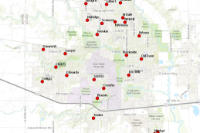

In [6]:
#Shapefile of interest we will enrich

#We will enrich the dataset

from arcgis.gis import GIS
from IPython.display import display
from arcgis.geoenrichment import *

gis = GIS("http://jllesp.maps.arcgis.com/home/index.html", "nacho.moreno_JLLesp", "montbla2")

#We search for the layer

search_results = gis.content.search('title:AMES', 'Feature Layer')

AMES_neighborhoods = search_results[1]

AMES_neighborhoods



Create a simple map to visualize the data

In [7]:
AMES_map = gis.map(location =[42.019676, -93.624323], zoomlevel = 11)
AMES_map.basemap = 'streets-vector'
AMES_map.add_layer(AMES_neighborhoods)

AMES_map

MapView(basemap='streets-vector', layout=Layout(height='400px', width='100%'), zoom=11.0)

We investigate which datasets we will be getting

In [ ]:
usa = Country.get('US')
usa.properties.datasets

datasets_esri = usa.data_collections

#These are the datasets we will be using

datasets_esri.loc['populationtotals']['analysisVariable'].unique()
datasets_esri.loc['lifemodegroupsNEW']['analysisVariable'].unique()
datasets_esri.loc['5yearincrements']['analysisVariable'].unique()
datasets_esri.loc['householdincome']['analysisVariable'].unique()
datasets_esri.loc['businesses']['analysisVariable'].unique()

We finally enrich the data

In [8]:
from arcgis.features import enrich_data
from arcgis.features import FeatureLayerCollection

data_collections = ['populationtotals','lifemodegroupsNEW','5yearincrements','householdincome','businesses']

analysis_variables= ['S12_BUS', 'S16_BUS', 'S24_BUS','MEDHINC_CY','AVGHINC_CY','PCI_CY','MEDAGE_CY','TLIFECODE','TLIFENAME','TOTPOP_CY']

AMES_enriched = enrich_data.enrich_layer(AMES_neighborhoods, buffer_type='StraightLine', distance=1 ,units='Kilometers', 
                                         data_collections= data_collections, analysis_variables = analysis_variables)

#How to transform a feature collection to a df, first we 'query' teh feature collection adn a 
#Featureset is returned, then we use the df method to transform to a pd dataframe 

#Documentation here https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featurecollection and
# here: https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featureset
AMES_enriched_df = AMES_enriched.query().df



In [10]:
#We export teh shapefile for further analysis

#For importing ArcPY you need to jsut open the jupyter notebook from teh browser and not from the Anaconda distribution
import arcpy

AMES_enriched.query().save(save_location= r'C:\Users\natxo\OneDrive\4_NYCDSA\4_NYCDSA_Bootcamp\0_Projects\3_Machine_Learning\3_EDA\Shapefile',
     out_name='Neighborhoods_enriched', encoding=None)



'C:\\Users\\natxo\\OneDrive\\4_NYCDSA\\4_NYCDSA_Bootcamp\\0_Projects\\3_Machine_Learning\\3_EDA\\Shapefile\\Neighborhoods_enriched2.shp'

In [9]:

#Lets change the name of the columns and clean the data
AMES_enriched_df = AMES_enriched_df.drop(['HasData', 'ID', 'ID_1', 'OBJECTID', 'ENRICH_FID', 'aggregationMethod', 'areaType', 'bufferUnits', 'sourceCountry', 'SHAPE' ], axis=1)
AMES_enriched_df = AMES_enriched_df.rename(index=str, columns={"AVGHINC_CY": "Average Household Income", 
                                                               "MEDAGE_CY": "Median Age",
                                                               "MEDHINC_CY": "Median Household Income",
                                                               "PCI_CY": "Per Capita Income",
                                                               "S12_BUS": "Food Stores (SIC54)",
                                                               "S16_BUS": "Eating & Drinking (SIC58)",
                                                               "S24_BUS": "Hotel/Lodging (SIC70)",
                                                               "TLIFECODE": "Dominant Tapestry LifeMode Group Code",
                                                               "TLIFENAME": "Dominant Tapestry LifeMode Group Name",
                                                               "TOTPOP_CY": "Total Population",
                                                               "bufferRadii": "Buffer Distance",
                                                               "bufferUnitsAlias": "Buffer Units" })

#Just to check we have the right data and save it ot a new dataframe and CSV so we dont need to run everytime
AMES_enriched_df.head(5)

,Average Household Income,Median Age,Median Household Income,Neighborhood,Per Capita Income,Food Stores (SIC54),Eating & Drinking (SIC58),Hotel/Lodging (SIC70),Dominant Tapestry LifeMode Group Code,Dominant Tapestry LifeMode Group Name,Total Population,Buffer Distance,Buffer Units
0,107120,45.0,73234,Timber,54059,1,1,1,5,GenXurban,1841,1,Kilometers
1,77663,28.3,53564,Veenker,34486,0,4,0,2,Upscale Avenues,3923,1,Kilometers
2,98860,40.0,75050,StoneBr,42476,2,5,0,4,Family Landscapes,3323,1,Kilometers
3,94082,34.4,81763,Somerst,39850,0,4,0,2,Upscale Avenues,4959,1,Kilometers
4,74934,29.7,58617,Sawyer,31749,0,1,0,5,GenXurban,3693,1,Kilometers


In [85]:
#Lets save the data in a CSV
AMES_enriched_df.to_csv('Neighborhoods_enriched.csv')

Last step is merge this data with our original data and save it to the original CSV

In [10]:
#Merge data and export to our original file for train and test
train_enriched = train.merge(AMES_enriched_df, on='Neighborhood')
train_enriched.to_csv('train_enriched.csv')


test_enriched = test.merge(AMES_enriched_df, on='Neighborhood')
test_enriched.to_csv('test_enriched.csv')

### Creating a Multivariate Classification with Arcpy

In [25]:
#we will be using the ESRI arcpy function

import arcpy

#With Kmeans we create a 5 classes cluster based on Total Population, Per Capita Income, Number of Eating & Drinking and Median Age

ga = arcpy.stats.MultivariateClustering(in_features=r'C:\Users\natxo\Documents\Local GIS\1_GIS_AMES\GIS_AMES\Neighborhoods_enriched.shp', 
                                   output_features=r'C:\Users\natxo\Documents\Local GIS\1_GIS_AMES\GIS_AMES\Neighborhoods_cluster.shp', 
                                   analysis_fields= ['S16_BUS','PCI_CY','MEDAGE_CY','TOTPOP_CY'], 
                                   clustering_method='K_MEANS', 
                                   initialization_method='OPTIMIZED_SEED_LOCATIONS', 
                                   initialization_field=None,
                                   number_of_clusters=5)



**Model Summary**

Variable-Wise Summary that were used to create each of the classes

     Variable        Mean    Std. Dev.         Min          Max       R2
 
      S16_BUS    8.440000    10.594640    0.000000    39.000000 0.769774
  
    MEDAGE_CY   33.396000     7.383846   21.100000    45.000000 0.769223

      PCI_CY 34818.160000 10671.912480 9956.000000 54059.000000 0.657214
   
    TOTPOP_CY 4418.080000  2454.761950 1841.000000 14098.000000 0.442192


In [20]:
#We will import this data and add it to the data frame and add a box plot to see how it relates to the variable neighborhood

import geopandas

#we read the data and will add the neighborhood name to the cluster dataframe
Neighborhoods_cluster_df = geopandas.read_file(r'C:\Users\natxo\Documents\Local GIS\1_GIS_AMES\GIS_AMES\Neighborhoods_cluster.shp')

#export this data to a df
Neighborhoods_cluster_df.to_csv('Neighborhoods_cluster.csv')

#did the join in excel and bring back teh file
Neighborhoods_cluster = pd.read_csv('Neighborhoods_cluster_name.csv') 

Neighborhoods_cluster.head()

,Unnamed: 0,SOURCE_ID,S16_BUS,PCI_CY,MEDAGE_CY,TOTPOP_CY,CLUSTER_ID,IS_SEED,geometry,Neighborhood
0,0,0,1,54059,45.0,1841,5,0,POINT (-10425020.6419 5160828.683400005),Timber
1,1,1,4,34486,28.3,3923,3,1,POINT (-10424724.0755 5167521.198399998),Veenker
2,2,2,5,42476,40.0,3323,5,0,POINT (-10422866.5126 5170052.045000009),StoneBr
3,3,3,4,39850,34.4,4959,4,0,POINT (-10424338.5392 5168410.897600003),Somerst
4,4,4,1,31749,29.7,3693,3,0,POINT (-10427274.0825 5165987.3684),Sawyer


In [27]:
#Lets add this data to our CSVs

#Merge data and export to our original file for train and test
train_enriched = train.merge(Neighborhoods_cluster, on='Neighborhood')
#drop teh extra columns
train_enriched.drop(['SOURCE_ID','S16_BUS','PCI_CY', 'MEDAGE_CY', 'TOTPOP_CY', 'IS_SEED', 'geometry', 'Unnamed: 0'], inplace=True, axis=1)
train_enriched = train_enriched.rename(index=str, columns={"CLUSTER_ID": 'GIS Cluster (K-means)'})
train_enriched.to_csv('train_enriched.csv')


test_enriched = test.merge(Neighborhoods_cluster, on='Neighborhood')
test_enriched.drop(['SOURCE_ID','S16_BUS','PCI_CY', 'MEDAGE_CY', 'TOTPOP_CY', 'IS_SEED', 'geometry', 'Unnamed: 0'], inplace=True, axis=1)
test_enriched = test_enriched.rename(index=str, columns={"CLUSTER_ID": 'GIS Cluster (K-means)'})
test_enriched.to_csv('test_enriched.csv')

train_enriched.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,GIS Cluster (K-means)
0,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,...,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900,2
1,917,20,C (all),50.0,9000,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,10,2006,WD,Abnorml,35311,2
2,31,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,7,2008,WD,Normal,40000,2
3,1326,30,RM,40.0,3636,Pave,NaN,Reg,Lvl,AllPub,...,NaN,MnPrv,NaN,0,1,2008,WD,Normal,55000,2
4,706,190,RM,70.0,5600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,Othr,3500,7,2010,WD,Normal,55000,2


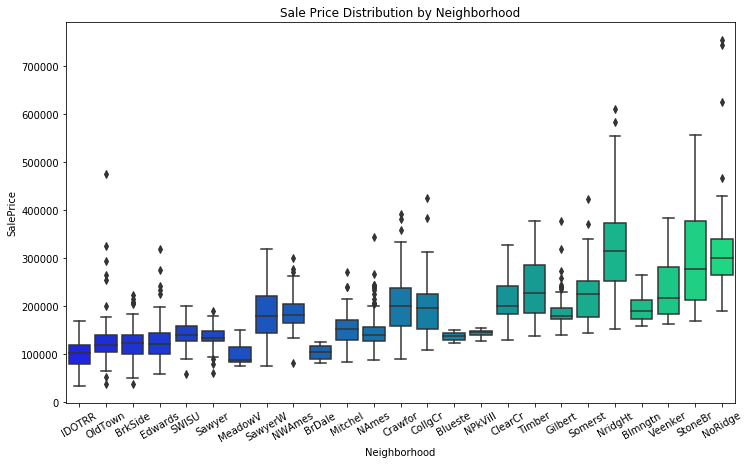

In [32]:
#Lets visualize the relation between both variables Neighborhood Cluester and sale price

plt.figure(figsize=(12, 7))
n = sns.boxplot(x='Neighborhood', y='SalePrice', data=train_enriched, palette='winter', )
n.set_xticklabels(train_enriched.Neighborhood.unique(), rotation = 30)
n.set_title('Sale Price Distribution by Neighborhood')
n

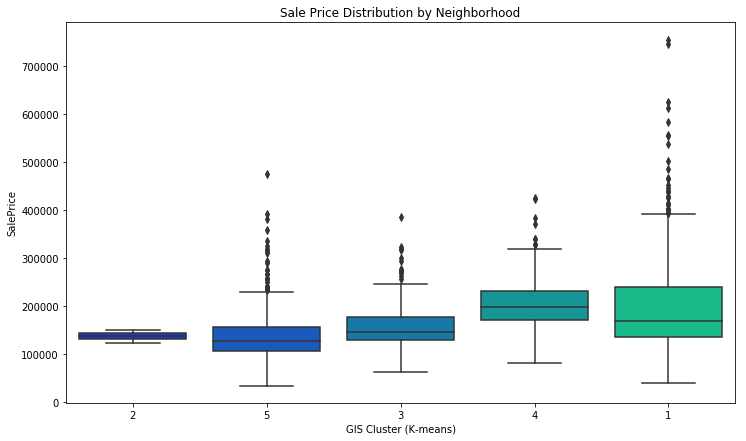

In [40]:
plt.figure(figsize=(12, 7))
n = sns.boxplot(x='GIS Cluster (K-means)', y='SalePrice', data=train_enriched, palette='winter', )
n.set_xticklabels(train_enriched['GIS Cluster (K-means)'].unique())
n.set_title('Sale Price Distribution by Neighborhood')
n

In [42]:
train_enriched['GIS Cluster (K-means)'].value_counts().sort_values(ascending=True)

1      2
3    210
2    326
4    337
5    585
Name: GIS Cluster (K-means), dtype: int64